In [1]:
import Main
import Parser
from Analyser import *

In [2]:
modelName = 'dereffye'

In [3]:
# Some PyABC magic to get our set of parameters
from pyabc import (ABCSMC, Distribution, RV, MultivariateNormalTransition)
import scipy as sp
import scipy.stats as st
import tempfile
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def model(params):
    return Main.generate_and_analyse(modelName, params)

In [5]:
t1 = Main.generate_and_analyse(modelName, {})
t1

{'parentAngle_mean': 17.562185524273115,
 'parentAngle_variance': 21.25184088858158,
 'length_mean': 1.4055027827336024,
 'length_variance': 0.9057108250017012,
 'verticalOrientation_mean': 55.460042610218736,
 'verticalOrientation_variance': 30.113353402380824,
 'horizontalOrientation_mean': 169.35119919457196,
 'horizontalOrientation_variance': 103.32736916627918,
 'q1_xyz': (21.926212753080296, 26.971163924556418, 27.22893222233252),
 'q2_xyz': (59.96238994148834, 25.185660767349074, 50.063207188097536),
 'q3_xyz': (63.150919419421164, 27.85496629777827, 51.347914271009884),
 'xyz': (63.51511915457697, 79.74730372746824, 57.19259310431773),
 'trunk_length': 10.0,
 'totalBiomass': 397.23712082645477}

In [6]:
metrics = {  'section_1_slash':(10, 100),
             'section_1_slashr':(10, 100),
          }

In [7]:
# prior = Distribution(section_1_slash     =RV("uniform", 10, 100),
#                      section_1_slashr    =RV("uniform", 10, 100),
#                      section_1_plus      =RV("uniform", 0, 180),
#                      section_1_plusr      =RV("uniform", 0, 180),
#                      section_1_decay     =RV("uniform", 0, 1),
#                      section_1_d         =RV("uniform", 0,1),
#                      section_1_h         =RV("uniform", 1, 20),
#                      section_1_w         =RV("uniform", 0.1, 2),
#                      general_thickness   =RV("uniform", 0, 5)
#                     )

In [8]:
angles = Distribution(section_1_slash     =RV("uniform", 10, 100),
                     section_1_slashr    =RV("uniform", 10, 100))

In [9]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db"))

In [10]:
def gen_av_target(n):
    target = model({})
    for i in range(n):
        print(i)
        new_metrics = model({})
        for (k,v) in new_metrics.items():
            if k[-3:] == 'xyz':
                x,y,z = target[k]
                x += new_metrics[k][0]
                y += new_metrics[k][1]
                z += new_metrics[k][2]
                target[k] = (x,y,z)
            else:
                target[k] += new_metrics[k]

    for (k,v) in target.items():
        if k[-3:] == 'xyz':
            x,y,z = target[k]
            target[k] = (x/n, y/n, z/n)
        else:
            target[k] /= n
            
    return target

In [11]:
target = gen_av_target(20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [12]:
target

{'parentAngle_mean': 18.286867366588137,
 'parentAngle_variance': 22.384705022119558,
 'length_mean': 1.4757779218702827,
 'length_variance': 0.9509963662517865,
 'verticalOrientation_mean': 59.54872920129592,
 'verticalOrientation_variance': 31.599519604462586,
 'horizontalOrientation_mean': 184.33256396687602,
 'horizontalOrientation_variance': 110.46421956976755,
 'q1_xyz': (21.54447927612688, 28.504720219783632, 32.33380226464395),
 'q2_xyz': (51.630697504359794, 26.471029316473494, 66.34028092857899),
 'q3_xyz': (46.556163361501284, 29.183171290926737, 51.3727099234301),
 'xyz': (55.412776737504046, 83.73466891384166, 69.10908845081214),
 'trunk_length': 10.5,
 'totalBiomass': 417.0989768677776}

In [13]:
mp = 7
me = 0.5

In [14]:
abc = ABCSMC(model, angles, distance)
abc.new(db_path, target)
history = abc.run(minimum_epsilon=me, max_nr_populations=mp)

INFO:History:Start <ABCSMC(id=55, start_time=2019-04-17 11:34:40.259397, end_time=None)>
INFO:Epsilon:initial epsilon is 6.537157820457902
INFO:ABC:t:0 eps:6.537157820457902
INFO:ABC:t:1 eps:5.241010061546622
INFO:ABC:t:2 eps:4.435573497807048
INFO:ABC:t:3 eps:3.7006765126912935
INFO:ABC:t:4 eps:3.2321920700781313
INFO:ABC:t:5 eps:2.696418303339832
INFO:ABC:t:6 eps:2.241465914961023
INFO:History:Done <ABCSMC(id=55, start_time=2019-04-17 11:34:40.259397, end_time=2019-04-17 11:38:21.759235)>


In [15]:
from pyabc.visualization import plot_kde_1d

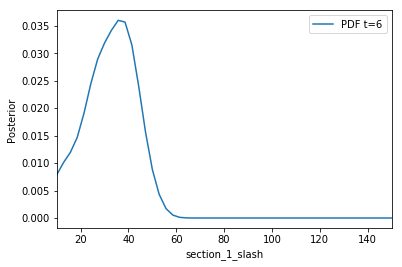

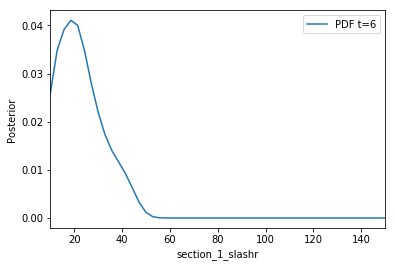

In [20]:
# Visualise results
for k,v in metrics.items():
    fig, ax = plt.subplots()
    for t in range(history.max_t, history.max_t+1):
        df, w = history.get_distribution(m=0, t=t)
        plot_kde_1d(df, w,
                    xmin=v[0], xmax=1.5*v[1],
                    x=k, ax=ax,
                    label="PDF t={}".format(t))
    ax.legend();
    fig.savefig('../../../../Report/images/dereffye_angles/'+k+'_kde')